In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete

device = 'cpu'

/home/chingf/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")
/home/chingf/Code/sr-project/datasets/sf_inputs_discrete.py:14: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
def format_dset_name(key):
    if 'pval50' in key:
        return '50% Sparsity'
    elif 'pval80' in key:
        return '80% Sparsity'
    elif 'pval95' in key:
        return '95% Sparsity'
    elif 'sparse' in key:
        return 'Localized'
    else:
        return 'Unknown'
    
def get_sigma(key):
    p = re.compile('.*sigma(.+)\/.*')
    if 'sigma' in key:
        m = p.match(key)
        return m.group(1)
    else:
        return '0'

# Calculate field statistics

In [5]:
# Area and Peaks

from findpeaks import findpeaks
from scipy.ndimage.measurements import label

def get_area_and_peaks(firing_field):
    masked_field = firing_field > 0.8
    labeled_array, ncomponents = label(masked_field, np.ones((3,3)))
    areas = []
    for label_id in np.unique(labeled_array):
        if label_id == 0: continue
        area = np.sum(labeled_array == label_id)
        if area < 2: continue
        areas.append(area)
    return areas, len(areas)

def get_metrics(outputs, dset):
    walk_xs = dset.xs.astype(int)
    walk_ys = dset.ys.astype(int)
    arena_length = 10
    
    areas = []
    ncomps = []
    
    for neur in np.arange(outputs.shape[1]):
        firing_field = np.zeros((arena_length, arena_length))*np.nan
        for x in range(arena_length):
            for y in range(arena_length):
                frame_idxs = np.logical_and(walk_xs == x, walk_ys == y)
                fr = np.nanmean(outputs[frame_idxs, neur])
                firing_field[x,y] = fr
        firing_field[np.isnan(firing_field)] = 0

        # Area?
        area, ncomp = get_area_and_peaks(firing_field)
        areas.append(np.sum(area))
        ncomps.append(ncomp)
    return np.array(areas), np.array(ncomps)

# Run each dataset

In [7]:
root_dir = "../trained_models/"
dset_dirs = [
    '03_td_discrete_uncorr/pval50/',
    '03_td_discrete_uncorr/pval80/',
    '03_td_discrete_uncorr/pval95/',
    '03_td_discrete_corr/pval50_sigma1.0/',
    '03_td_discrete_corr/pval50_sigma1.25/',
    '03_td_discrete_corr/pval50_sigma1.5/',
    '03_td_discrete_corr/pval50_sigma1.75/',
    '03_td_discrete_corr/pval50_sigma2.0/',
    '03_td_discrete_corr/pval80_sigma1.0/',
    '03_td_discrete_corr/pval80_sigma1.25/',
    '03_td_discrete_corr/pval80_sigma1.5/',
    '03_td_discrete_corr/pval80_sigma1.75/',
    '03_td_discrete_corr/pval80_sigma2.0/',
    '03_td_discrete_corr/pval95_sigma1.0/',
    '03_td_discrete_corr/pval95_sigma1.25/',
    '03_td_discrete_corr/pval95_sigma1.5/',
    '03_td_discrete_corr/pval95_sigma1.75/',
    '03_td_discrete_corr/pval95_sigma2.0/',
    '03_td_discrete_corr/sparse_sigma1.0/',
    '03_td_discrete_corr/sparse_sigma1.25/',
    '03_td_discrete_corr/sparse_sigma1.5/',
    '03_td_discrete_corr/sparse_sigma1.75/',
    ]

dset_names = []
gammas = []
sigmas = []
field_areas = []
field_nums = []
p_one_field = []

for dset_dir in dset_dirs:
    dset_name = format_dset_name(dset_dir)
    sigma = get_sigma(dset_dir)
    for gamma in os.listdir(f'{root_dir}{dset_dir}'):
        gamma_dir = f'{root_dir}{dset_dir}{gamma}/'
        model_dir = f'{gamma_dir}rnn_fixedlr_alpha/'
        for _iter in os.listdir(model_dir):
            iter_dir = model_dir + _iter + '/'
            results_path = iter_dir + 'results.p'
            with open(results_path, 'rb') as f:
                results = pickle.load(f)
            outputs = results['outputs']
            dset = results['dset']
            areas, ncomps = get_metrics(outputs, dset)
            dset_names.append(dset_name)
            gammas.append(gamma)
            sigmas.append(sigma)
            field_areas.append(np.mean(areas)/100)
            field_nums.append(np.mean(ncomps))
            p_one_field.append(np.sum(ncomps==1)/ncomps.size)

# Make plots

In [8]:
df = pd.DataFrame({
    'Dataset': dset_names,
    'Gamma': gammas,
    'Sigma': sigmas,
    'Field Area': field_areas,
    'Number of Fields': field_nums,
    'One Field Only': p_one_field
    })

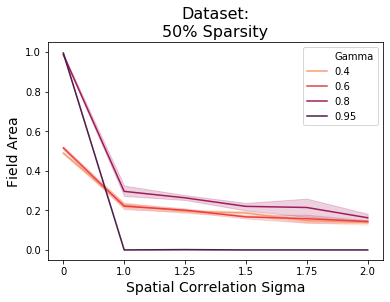

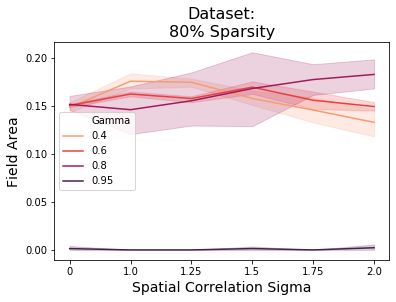

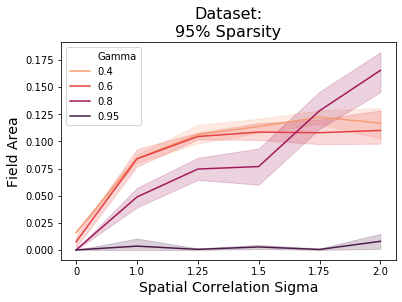

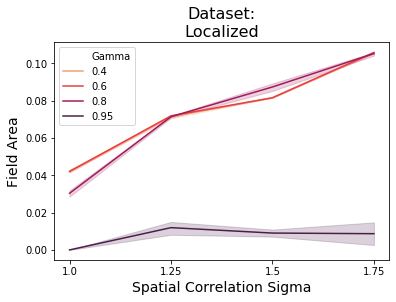

In [17]:
for dset_name in np.unique(dset_names):
    fig, ax = plt.subplots()
    sns.lineplot(
        x='Sigma', y='Field Area',
        hue='Gamma', palette=sns.color_palette('rocket_r', n_colors=4),
        data=df[df['Dataset']==dset_name],
        ax=ax
        )
    plt.title(f'Dataset:\n{dset_name}', fontsize=16)
    plt.xlabel('Spatial Correlation Sigma', fontsize=14)
    plt.ylabel('Field Area', fontsize=14)
    plt.show()